<a href="https://colab.research.google.com/github/jocksanv/neuroDecoding/blob/main/geometric_decoding_class_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tinyurl.com/attn-geometry

Material for the 2024 course on the Geometry of Neural Representations (part of Columbia’s graduate course in Advanced Topics in Theoretical Neuroscience). Lorenzo Posani & Valeria Fascianelli.


The scope of this exercise is to simulate the case in which we want to analyze a collection of neural recordings from different areas recorded during the same experimental setup.

Our job in this exercise is to use linear classifiers and geometrical analysis to understand **in what geometry these areas represent the experimental variables**.

---
**Resources:**

- See the course from last year for pitfalls and best practices in neural decoding [tinyurl.com/ArtDecod](https://tinyurl.com/ArtDecod))

- Check out [Decodanda](https://github.com/lposani/decodanda) for a Python package that implements all these analyses in a user-friendly way.

---

In our simulated experiment, subjects are shown two different stimuli (A and B) and are trained to respond with an action (left or right). Due to the experimental design, the data will be unbalanced, adding a frequent complication that, as we will see, is important to discuss.

<div style="display: flex; justify-content: row;">
    <img src="https://github.com/lposani/geometric_decoding_class/blob/main/img/conditions-intro.png?raw=true">
</div>

As explained in the first part of the lecture, different geometries have important computational implications on the neural code. Here, we will use an *inverse approach*, and try to infer the geometry from the computational properties of neural recordings.

We will use linear decoders and CCGP, as explained in these schemes:

<div style="display: flex; justify-content: row;">
    <img src="https://github.com/lposani/geometric_decoding_class/blob/main/img/conditions-dichotomies.png?raw=true">
</div>

Due to their specific computational implications, different geometries will imply different combinations of decoding performances and CCGP values. We will use these **geometrical fingerprints** to infer the representational geometry of each area:

<div style="display: flex; justify-content: row;">
    <img src="https://github.com/lposani/geometric_decoding_class/blob/main/img/decoding-fingerprints.png?raw=true">
</div>

Let's see how it is done in practice!


In [ ]:
#@markdown #### Loading data sets
#@markdown We will use four synthetic data sets that simulate recordings from four areas:
#@markdown - Visual area (``datasets/VISp.pck``)
#@markdown - Motor area (``datasets/MOp.pck``)
#@markdown - Hippocampus (``datasets/HPC.pck``)
#@markdown - Prefrontal cortex (``datasets/PFC.pck``)

#@markdown Each recording consists of a (T trials x N neurons) matrix of mean activity during each trial

#@markdown Each trial is labeled according to the presented stimulus and the subsequent action.

!git clone https://github.com/lposani/geometric_decoding_class.git

import pickle
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_VIS = pickle.load(open('./geometric_decoding_class/datasets/VISp.pck', 'rb'))
data_MO = pickle.load(open('./geometric_decoding_class/datasets/MOp.pck', 'rb'))
data_HPC = pickle.load(open('./geometric_decoding_class/datasets/HPC.pck', 'rb'))
data_PFC = pickle.load(open('./geometric_decoding_class/datasets/PFC.pck', 'rb'))


Cloning into 'geometric_decoding_class'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 53 (delta 17), reused 47 (delta 11), pack-reused 0
Receiving objects: 100% (53/53), 4.94 MiB | 10.64 MiB/s, done.
Resolving deltas: 100% (17/17), done.


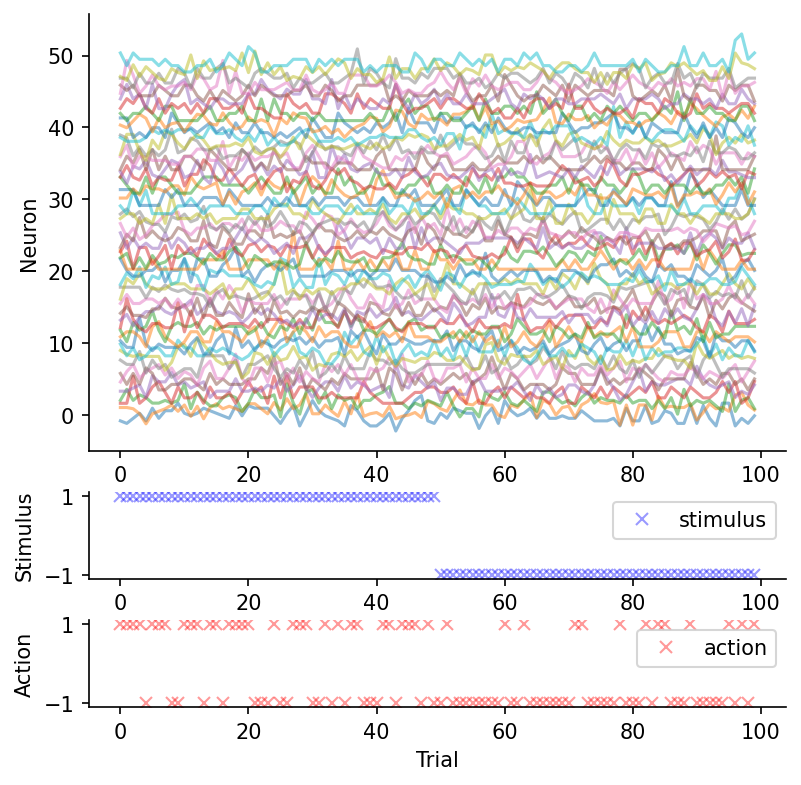

In [ ]:
#@markdown #### First visualization
#@markdown It's always a good idea to visualize the raw data to get a sense of behavior and activity:

f, axs = plt.subplots(3, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [5, 1, 1]})
raster = data_VIS['raster']
stimulus = data_VIS['stimulus']
action = data_VIS['action']
n_visualize = 50

for n in range(n_visualize):
  z_scored_x = (raster[:, n] - np.nanmean(raster[:, n])) / np.nanstd(raster[:, n])
  axs[0].plot(z_scored_x + n, alpha=0.5)
axs[0].set_ylabel('Neuron')

axs[1].plot(stimulus, label='stimulus', linewidth=4, alpha=0.4, linestyle='', marker='x', color='b')
axs[1].legend()
axs[1].set_ylabel('Stimulus')
axs[1].set_yticks([-1, 1])

axs[2].plot(action, label='action', linewidth=4, alpha=0.4, linestyle='', marker='x', color='r')
axs[2].legend()
axs[2].set_xlabel('Trial')
axs[2].set_ylabel('Action')
axs[2].set_yticks([-1, 1])

sns.despine(f)


#### Split into conditions
Our first job is to create a function that divides neural data into the four conditions according to behavior

In [ ]:
# Create a condition splitter from neural data and behavior

def divide_data_into_conditions(raster, stimulus, action):
  conditions = {}
  conditions['A<'] = raster[(stimulus == -1) & (action == -1)]
  conditions['A>'] = raster[(stimulus == -1) & (action == 1)]
  conditions['B<'] = raster[(stimulus == 1) & (action == -1)]
  conditions['B>'] = raster[(stimulus == 1) & (action == 1)]
  return conditions


## Balanced Dichotomy Decoding
Second, we will use linear decoding to understand what information about the experimental variables is accessible to linear classifiers.

Let's try to implement a cross-validated balanced decoding pipeline for the **stimulus** dichotomy.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

conditions_VIS = divide_data_into_conditions(data_VIS['raster'], data_VIS['stimulus'], data_VIS['action'])

# Create a balanced decoding function (stimulus)

cv_performances = []
max_data = np.max([conditions_VIS[c].shape[0] for c in conditions_VIS])
for k in range(20):
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []
  for c in conditions_VIS:
      train_c, test_c = train_test_split(conditions_VIS[c], train_size=0.75)
      train_c = resample(train_c, replace=True, n_samples=max_data)
      training_data.append(train_c)
      testing_data.append(test_c)
      if c[0] == 'A':
        training_labels.append(-1*np.ones(len(train_c)))
        testing_labels.append(-1*np.ones(len(test_c)))
      if c[0] == 'B':
        training_labels.append(np.ones(len(train_c)))
        testing_labels.append(np.ones(len(test_c)))

      X_train = np.vstack(training_data)
      y_train = np.hstack(training_labels)

      X_test = np.vstack(testing_data)
      y_test = np.hstack(testing_labels)

  svc = LinearSVC(max_iter=1000000)
  svc.fit(X_train, y_train)
  perf = svc.score(X_test, y_test)
  cv_performances.append(perf)


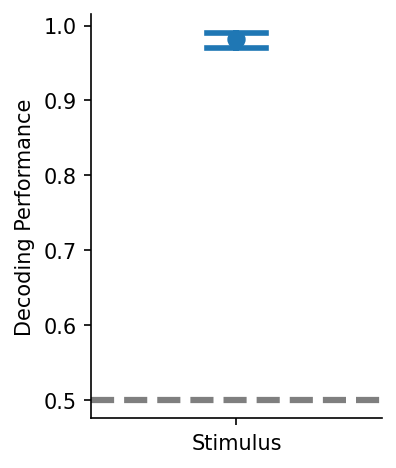

In [ ]:
#@markdown let's visualize the performance:

f, ax = plt.subplots(figsize=(2.5, 3.5))
sns.pointplot({'Stimulus': cv_performances}, orient='v', capsize=.2)
ax.set_ylabel('Decoding Performance')
sns.despine(ax=ax)
ax.axhline([0.5], linestyle='--', color='k', linewidth=3, alpha=0.5)

Pretty good! But expected, since we are in the visual area. What happens for the other dichotomies (Action and XOR)?

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Create a balanced decoding function

def linearDecode(conditions, label1='stimulus', label2='action', training_fraction=0.75, cross_validations=20, ax=None):
  performances = {label1: [], label2: [], 'XOR': []}
  max_ndata = max([len(c) for c in conditions])

  # decode three variables
  for k in range(cross_validations):
    training_data = []
    testing_data = []

    testing_labels_1 = []
    training_labels_1 = []

    testing_labels_2 = []
    training_labels_2 = []

    testing_labels_XOR = []
    training_labels_XOR = []

    for c in conditions:
      training_data_condition, testing_data_condition = train_test_split(conditions[c], train_size=training_fraction)

      # Balance conditions:
      training_data_condition = resample(training_data_condition, replace=True, n_samples=max_ndata)
      # --- try to comment this ^

      training_data.append(training_data_condition)
      testing_data.append(testing_data_condition)

      # label according to stimulus
      if c[0] == 'A':
        training_labels_1.append(np.zeros(len(training_data_condition)))
        testing_labels_1.append(np.zeros(len(testing_data_condition)))
      if c[0] == 'B':
        training_labels_1.append(np.ones(len(training_data_condition)))
        testing_labels_1.append(np.ones(len(testing_data_condition)))

      # label according to action
      if c[1] == '<':
        training_labels_2.append(np.zeros(len(training_data_condition)))
        testing_labels_2.append(np.zeros(len(testing_data_condition)))
      if c[1] == '>':
        training_labels_2.append(np.ones(len(training_data_condition)))
        testing_labels_2.append(np.ones(len(testing_data_condition)))

      # label according to XOR
      if ((c[0] == 'A') and (c[1] == '<')) or ((c[0] == 'B') and (c[1] == '>')):
        training_labels_XOR.append(np.zeros(len(training_data_condition)))
        testing_labels_XOR.append(np.zeros(len(testing_data_condition)))
      else:
        training_labels_XOR.append(np.ones(len(training_data_condition)))
        testing_labels_XOR.append(np.ones(len(testing_data_condition)))

    # prepare the arrays
    training_data = np.vstack(training_data)
    testing_data = np.vstack(testing_data)

    training_labels_1 = np.hstack(training_labels_1)
    testing_labels_1 = np.hstack(testing_labels_1)

    training_labels_2 = np.hstack(training_labels_2)
    testing_labels_2 = np.hstack(testing_labels_2)

    training_labels_XOR = np.hstack(training_labels_XOR)
    testing_labels_XOR = np.hstack(testing_labels_XOR)

    # train and test for variable 1
    svc = LinearSVC(max_iter=1000000)
    svc.fit(X=training_data, y=training_labels_1)
    perf = svc.score(X=testing_data, y=testing_labels_1)
    performances[label1].append(perf)

    # train and test for variable 2
    svc = LinearSVC(max_iter=1000000)
    svc.fit(X=training_data, y=training_labels_2)
    perf = svc.score(X=testing_data, y=testing_labels_2)
    performances[label2].append(perf)

    # train and test for variable XOR
    svc = LinearSVC(max_iter=1000000)
    svc.fit(X=training_data, y=training_labels_XOR)
    perf = svc.score(X=testing_data, y=testing_labels_XOR)
    performances['XOR'].append(perf)

  if ax is None:
    f, ax = plt.subplots(figsize=(3, 3.5))
  sns.despine(ax=ax)
  sns.pointplot(performances, ax=ax, linestyle='', capsize=.2)
  ax.set_ylabel('Decoding Performance (linear SVC)')
  ax.axhline([0.5], color='k', linestyle='--', linewidth=3, alpha=0.5)
  ax.set_ylim([0.35, 1.0])
  return performances


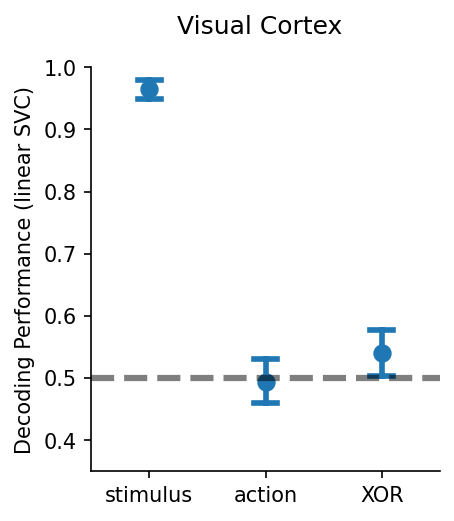

In [ ]:
# Decoding recordings from the visual area:
np.random.seed(0)
conditions_VIS = divide_data_into_conditions(data_VIS['raster'], data_VIS['stimulus'], data_VIS['action'])
performances = linearDecode(conditions_VIS, 'stimulus', 'action')
_ = plt.suptitle('Visual Cortex')

# Try to comment the resampling part above and see what happens!

## CCGP
Let's write a function that computes CCGP from the conditions

In [ ]:
# What about CCGP?


def CCGP(conditions, label1='stimulus', label2='action', ax=None, n_resamples=10):
  performances = {label1: [], label2: []}
  max_ndata = max([len(c) for c in conditions])

  for k in range(n_resamples):
    resampled_conditions = {key: resample(conditions[key], replace=True, n_samples=max_ndata) for key in conditions}


    # CCGP for variable 1: train A< vs. B< - test A> vs B>
    train_data_1 = np.vstack([resampled_conditions['A<'], resampled_conditions['B<']])
    train_labels_1 = np.hstack([np.zeros(max_ndata), np.ones(max_ndata)])

    test_data_1 = np.vstack([resampled_conditions['A>'], resampled_conditions['B>']])
    test_labels_1 = np.hstack([np.zeros(max_ndata), np.ones(max_ndata)])
    perf1 = LinearSVC().fit(X=train_data_1, y=train_labels_1).score(X=test_data_1, y=test_labels_1)
    perf2 = LinearSVC().fit(X=test_data_1, y=test_labels_1).score(X=train_data_1, y=train_labels_1)
    performances[label1].append(np.nanmean([perf1, perf2]))


    # CCGP for variable 1: train A< vs. A> - test B< vs B>
    train_data_2 = np.vstack([resampled_conditions['A<'], resampled_conditions['A>']])
    train_labels_2 = np.hstack([np.zeros(max_ndata), np.ones(max_ndata)])

    test_data_2 = np.vstack([resampled_conditions['B<'], resampled_conditions['B>']])
    test_labels_2 = np.hstack([np.zeros(max_ndata), np.ones(max_ndata)])
    perf1 = LinearSVC(max_iter=1000000).fit(X=train_data_2, y=train_labels_2).score(X=test_data_2, y=test_labels_2)
    perf2 = LinearSVC(max_iter=1000000).fit(X=test_data_2, y=test_labels_2).score(X=train_data_2, y=train_labels_2)
    performances[label2].append(np.nanmean([perf1, perf2]))

  if ax is None:
    f, ax = plt.subplots(figsize=(3, 3.5))
  sns.despine(ax=ax)
  sns.pointplot(performances, ax=ax, capsize=.2, linestyle='', marker='s')
  ax.set_ylabel('CCGP')
  ax.axhline([0.5], color='k', linestyle='--', linewidth=3, alpha=0.5)
  ax.set_ylim([0.35, 1.0])

  return performances


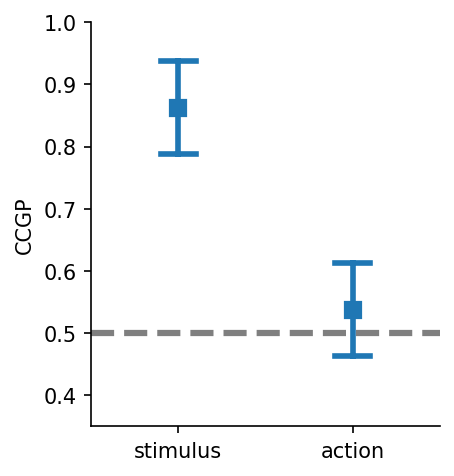

In [ ]:
# Let's try it on the visual conditions:
np.random.seed(0)
ccgps = CCGP(conditions_VIS, 'stimulus', 'action')


The neural data seems to encode only for one variable, which makes for a "trivial" abstract representation. Thus, the resulting geometry is linear.

We can even see that with PCA:

<div style="display: flex; justify-content: row;">
    <img src="https://github.com/lposani/geometric_decoding_class/blob/main/img/visual_pca.png?raw=true">
</div>


## Motor area

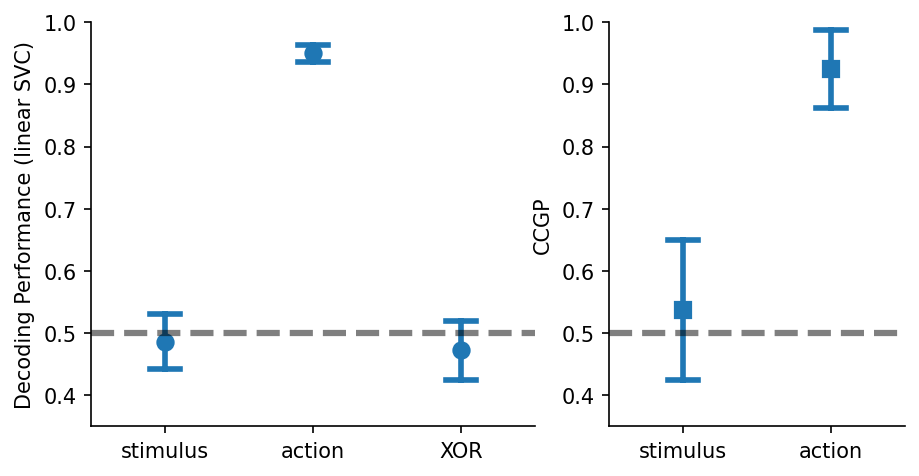

In [ ]:
# What about the other areas?

# Let's try with the Motor area
conditions_MO = divide_data_into_conditions(data_MO['raster'], data_MO['stimulus'], data_MO['action'])

f, axs = plt.subplots(1, 2, figsize=(7, 3.5), gridspec_kw={'width_ratios': [3, 2]})
res = linearDecode(conditions=conditions_MO, ax=axs[0])
res = CCGP(conditions=conditions_MO, ax=axs[1])


## Hippocampus
Pretty boring - let's try the Hippocampus:

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Text(0.5, 0.98, 'Hippocampus')

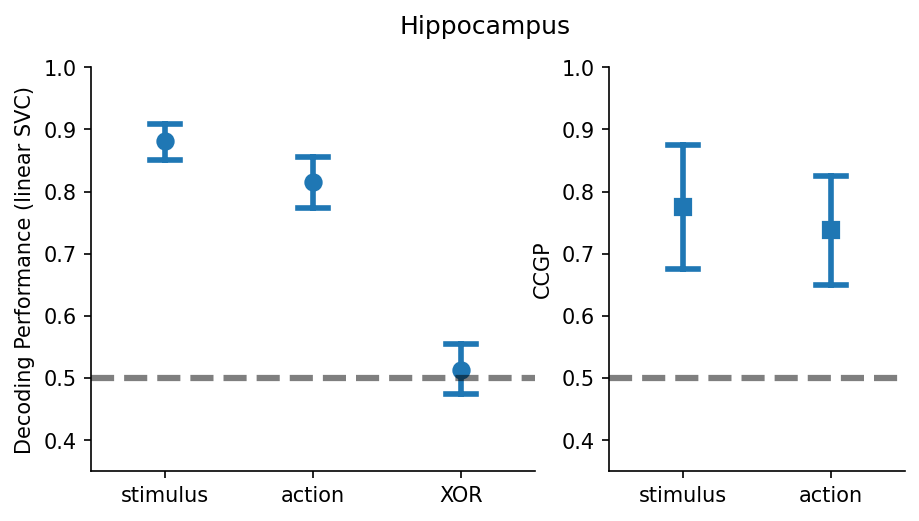

In [ ]:
# HPC
np.random.seed(0)

conditions_HPC = divide_data_into_conditions(data_HPC['raster'], data_HPC['stimulus'], data_HPC['action'])

f, axs = plt.subplots(1, 2, figsize=(7, 3.5), gridspec_kw={'width_ratios': [3, 2]})
res = linearDecode(conditions=conditions_HPC, ax=axs[0])
res = CCGP(conditions=conditions_HPC, ax=axs[1])
plt.suptitle('Hippocampus')

Well well, it looks like we have an abstract, square-like representation of stimulus and action in the Hippocampus. The PCA projection seem to confirm this result:


<div style="display: flex; justify-content: row;">
    <img src="https://github.com/lposani/geometric_decoding_class/blob/main/img/hpc_pca.png?raw=true">
</div>


## PFC
Finally, let's test data from the prefrontal area

Text(0.5, 0.98, 'PFC')

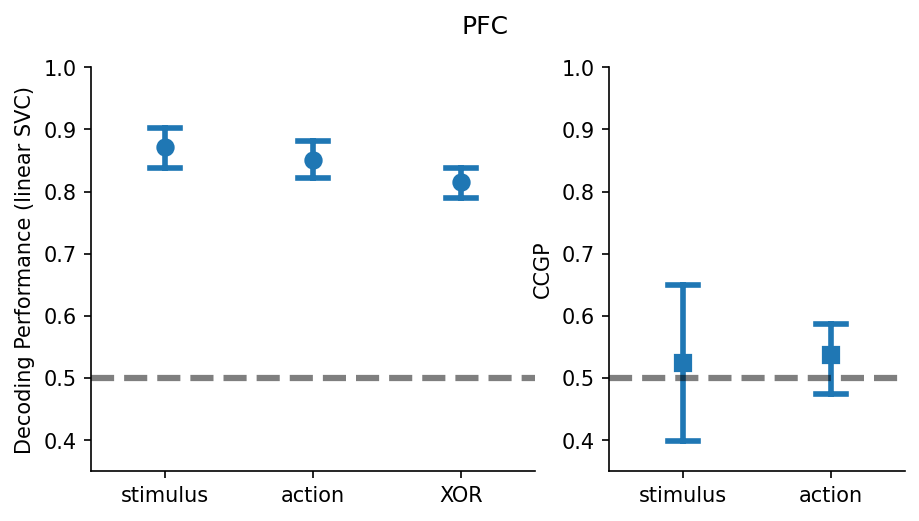

In [ ]:
# PFC
conditions_PFC = divide_data_into_conditions(data_PFC['raster'], data_PFC['stimulus'], data_PFC['action'])
np.random.seed(1)
f, axs = plt.subplots(1, 2, figsize=(7, 3.5), gridspec_kw={'width_ratios': [3, 2]})
res = linearDecode(conditions=conditions_PFC, ax=axs[0])
res = CCGP(conditions=conditions_PFC, ax=axs[1])
plt.suptitle('PFC')

It seems that our simulated PFC encodes all the variables but none of them in an abstract way. This is compatible with an unstructured, non-linearly mixed geometry - i.e. a tetrahedron:



<div style="display: flex; justify-content: row;">
    <img src="https://github.com/lposani/geometric_decoding_class/blob/main/img/pfc_pca.png?raw=true">
</div>


# Decodanda

If you want an easy way to implement all this and more, try [Decodanda](https://github.com/lposani/decodanda).

Decodanda (dog-latin for "to be decoded") is a Python package for decoding and geometrical analysis of neural activity.

It is designed to expose a user-friendly and flexible interface for population activity decoding, avoiding the most common pitfalls by a series of built-in best practices:

- Cross-validation is automatically implemented using a default or specified trial structure
- All analyses come with a built-in null model to test the significance of the data performance
- Multi-sessions pooling to create pseudo-populations is supported out of the box
- The individual contributions of multiple correlated experimental variables are isolated by cross-variable data balancing, avoding the confounding effects of correlated variables


In [ ]:
# Let's see how easy it is
! pip install decodanda


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 920.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0


In [ ]:
# First, build a Decodanda object to separate the neural data
# into conditions according to specified behavioral arrays
from decodanda import *
dec = Decodanda(data=data_HPC, conditions={'stimulus': [-1, 1], 'action': [-1, 1]}, verbose=True)


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1, action = -1):	Selected 37 time bin out of 100, divided into 37 trials - 200 neurons
			(stimulus = -1, action = 1):	Selected 13 time bin out of 100, divided into 13 trials - 200 neurons
			(stimulus = 1, action = -1):	Selected 20 time bin out of 100, divided into 20 trials - 200 neurons
			(stimulus = 1, action = 1):	Selected 30 time bin out of 100, divided into 30 trials - 200 neurons




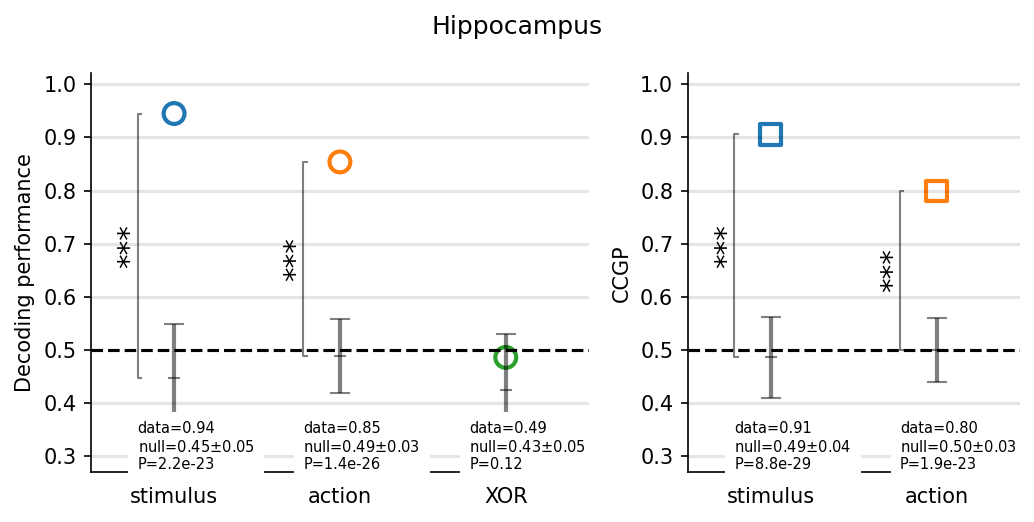

In [ ]:
np.random.seed(0)
dec._verbose = False
f, axs = plt.subplots(1, 2, figsize=(7, 3.5), gridspec_kw={'width_ratios': [3, 2]})
# Then compute decoding performances with one line of code:
perfs, null_perfs = dec.decode(training_fraction=0.8, non_semantic=True,
                               nshuffles=4, cross_validations=10,
                               plot=True, ax=axs[0], ndata=100)

# Same for CCGP:
ccgps, null_ccgps = dec.CCGP(nshuffles=10, plot=True, ax=axs[1], ndata=100)

_ = plt.suptitle('Hippocampus')


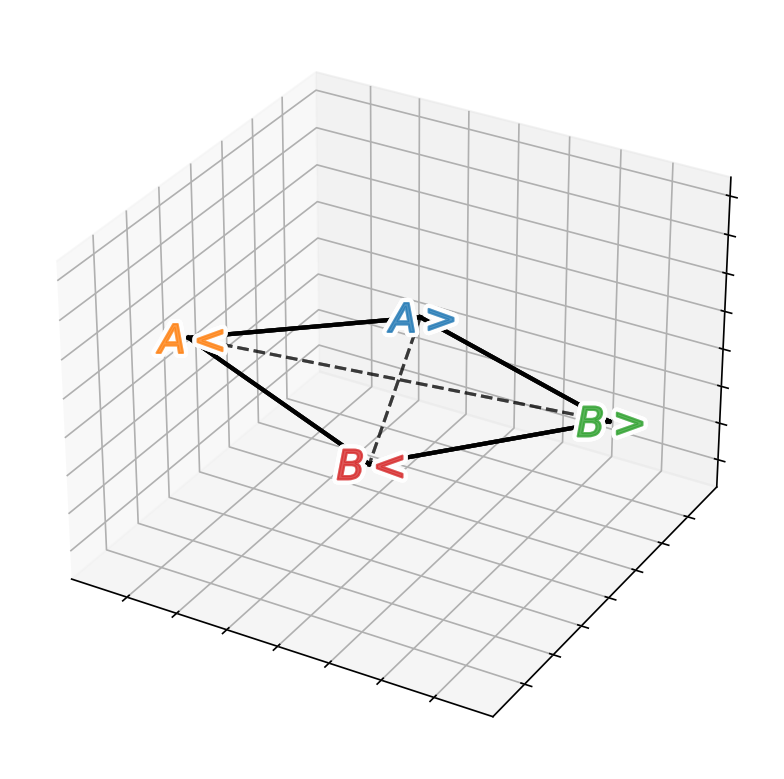

In [ ]:

# and for PCA visualization:
f = dec.visualize_PCA(mean=True, names=['A>', 'A<', 'B>', 'B<'], ndata=200)

What if you have a 3-variables setting? For example, you add a context variable to the experiment above:

In [ ]:

def generate_gaussian_disentangled3(n_neurons, n_trials, signal=1, rotated=False, label_A='A', label_B='B',
                                    label_C='C'):
    # sample behavior
    behavior_A = 2 * (np.random.rand(n_trials) < 0.5) - 1
    behavior_B = 2 * (np.random.rand(n_trials) < 0.5) - 1
    behavior_C = 2 * (np.random.rand(n_trials) < 0.5) - 1

    # sample neural parameters
    r = np.abs(np.random.randn(n_neurons) * signal)

    # sample activity
    raster = []
    for n in range(n_neurons):
        x = np.zeros(n_trials)
        for A in [-1, 1]:
            for B in [-1, 1]:
                for C in [-1, 1]:
                    mask = (behavior_B == B) & (behavior_A == A) & (behavior_C == C)
                    if (n % 3) == 0:
                        mean = r[n] * A
                    if (n % 3) == 1:
                        mean = r[n] * B
                    if (n % 3) == 2:
                        mean = r[n] * C
                    activity = np.random.randn(np.sum(mask)) + mean
                    x[mask] = activity
        raster.append(x)

    raster = np.asarray(raster)
    session = {
        'raster': raster.T,
        'trial': np.arange(n_trials),
        label_A: behavior_A,
        label_B: behavior_B,
        label_C: behavior_C
    }

    if rotated:
        R = special_ortho_group.rvs(n_neurons)
        session['raster'] = np.asarray([np.dot(x, R) for x in session['raster']])

    return session

session = generate_gaussian_disentangled3(n_neurons=300, n_trials=200)


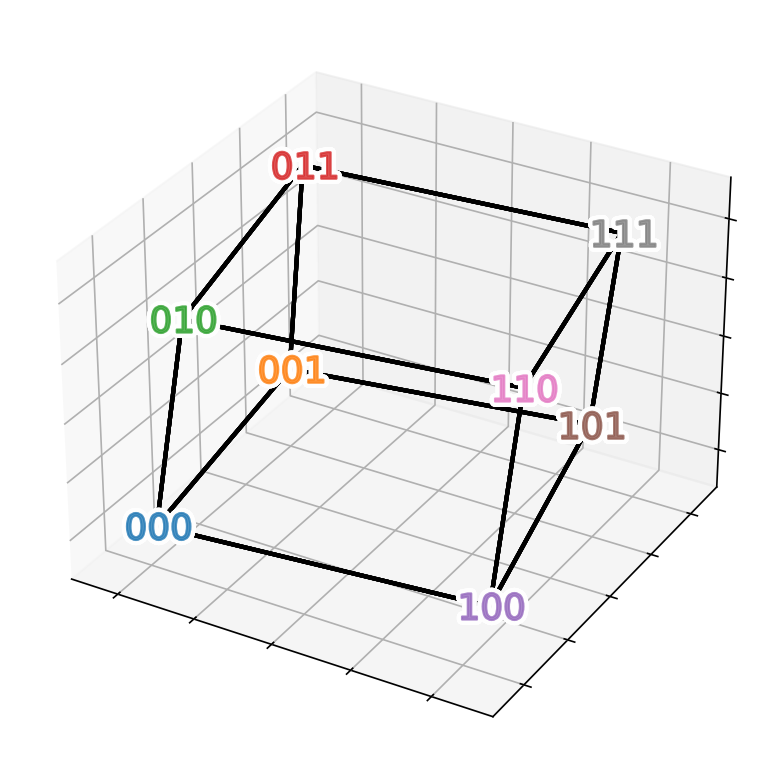

In [ ]:
dec = Decodanda(data=session, conditions={'A': [-1, 1], 'B': [-1, 1], 'C': [-1,1]})
f = dec.visualize_PCA(mean=True, ndata=200, draw_hd2_lines=False)


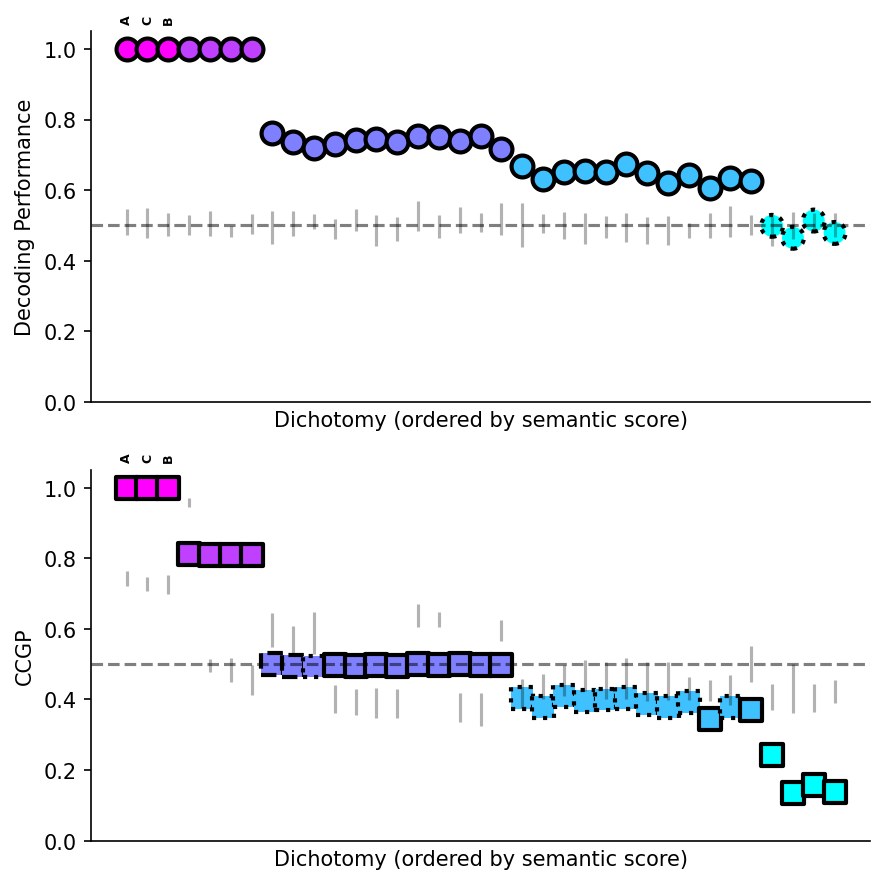

In [ ]:
# This function analyzes the decoding performance and CCGP for
# all 35 dichotomies, and orders them according to how close
# each dichotomy is to a semantic one (i.e., the variables we specify)

# It takes a few minutes to run here, so be patient if you want to run this cell

res = dec.semantic_score_geometry(nshuffles=10, cross_validations=10)
